In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.layers.core import Dense,Flatten
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
from PIL import Image
from tensorflow.keras.utils import img_to_array

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#Generating DataSet
path_root = "malimg_paper_dataset_imgs"
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(128,128), batch_size=8500)
imgs, labels = next(batches)
print(labels)


#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

Found 9339 images belonging to 25 classes.
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [5]:
np.min(X_train),np.max(X_train)

(0.0, 1.0)

In [6]:
X_train.shape

(5950, 128, 128, 3)

In [7]:
X_test.shape

(2550, 128, 128, 3)

In [8]:
class_indices = np.argmax(y_train, axis=1)
y_train = class_indices.reshape((-1, 1))
y_train.shape

(5950, 1)

In [9]:
class_indices = np.argmax(y_test, axis=1)
y_test = class_indices.reshape((-1, 1))
y_test.shape

(2550, 1)

In [10]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [11]:
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  25
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [12]:
X_train_flat = X_train.reshape(-1,49152)
X_train_flat.shape

(5950, 49152)

In [13]:
X_test_flat = X_test.reshape(-1,49152)
X_test_flat.shape

(2550, 49152)

In [18]:
feat_cols = ['pixel'+str(i) for i in range(X_train_flat.shape[1])]
df_mal = pd.DataFrame(X_train_flat,columns=feat_cols)
df_mal['label'] = y_train
print('Size of the dataframe: {}'.format(df_mal.shape))

Size of the dataframe: (5950, 49153)


In [19]:
pip install sparsepca

Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklearn.decomposition import MiniBatchSparsePCA

spca = MiniBatchSparsePCA(n_components=30, alpha=0.1, ridge_alpha=0.01, max_iter=1000)
spca.fit(X_train_flat)

# Transform the data to the new space (sparse representation)
X_sparse = spca.transform(X_train_flat)

# Print the transformed data
print("Original data shape:", X_train_flat.shape)
print("Sparse representation shape:", X_sparse.shape)

Original data shape: (5950, 49152)
Sparse representation shape: (5950, 30)


In [21]:
X_test_sparse = spca.transform(X_test_flat)
X_test_sparse.shape

(2550, 30)

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create an MLP classifier
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42)

# Train the model
model.fit(X_sparse, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_sparse)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/home/saadrupai/anaconda3/envs/Thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9749019607843137


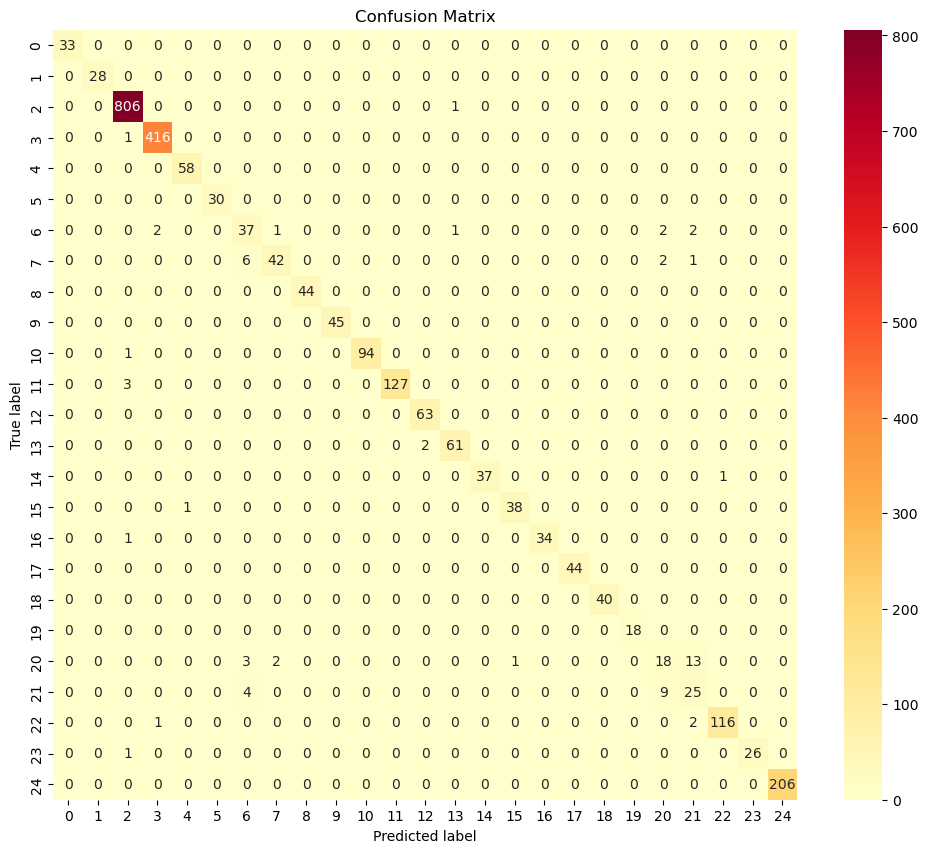

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are the true and predicted labels, respectively, of shape (2550, 1) and (2550,)

# Reshape y_test and y_pred
y_test = np.reshape(y_test, (2550,))
y_pred = np.reshape(y_pred, (2550,))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix with a different color scheme
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='d', xticklabels=np.arange(25), yticklabels=np.arange(25))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

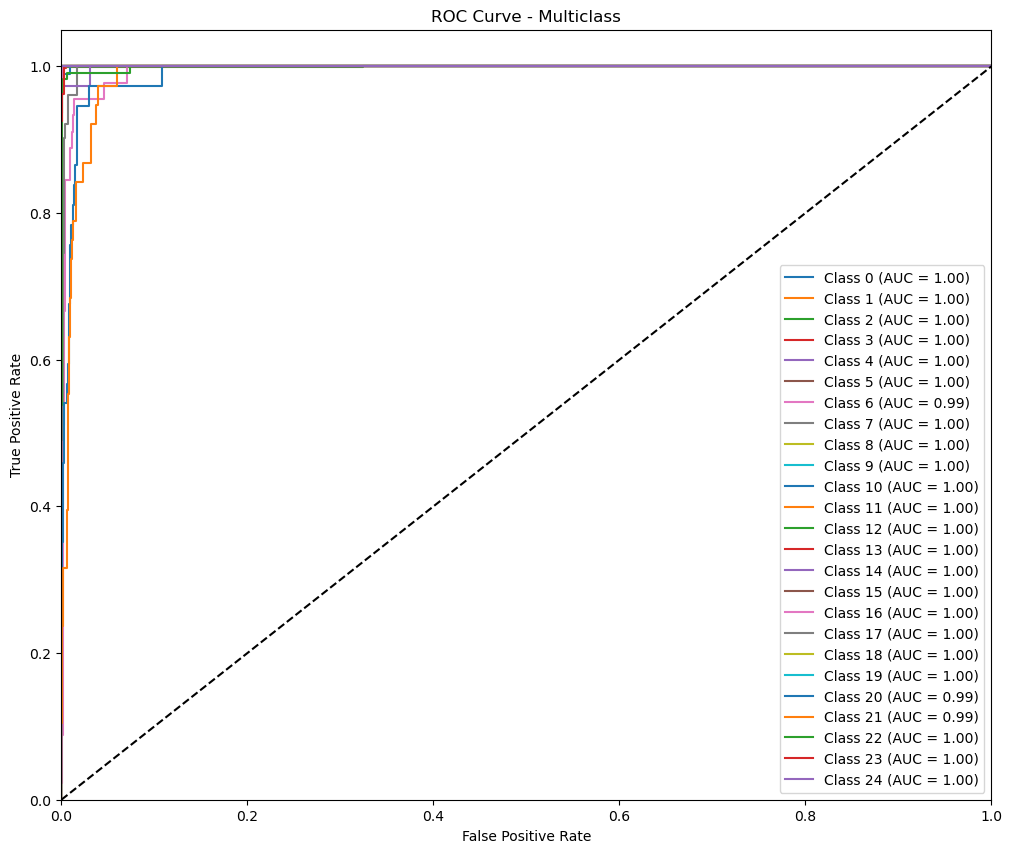

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier

# Assuming y_test and y_pred are the true and predicted labels, respectively, of shape (2550, 1) and (2550,)

# Reshape y_test and y_pred
y_test = np.reshape(y_test, (2550,))
y_pred = np.reshape(y_pred, (2550,))

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.arange(25))

# Create an MLP classifier
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42)

# Create a OneVsRestClassifier
ovr_model = OneVsRestClassifier(model)

# Fit the classifier and predict probabilities
ovr_model.fit(X_sparse, y_train)
y_pred_proba = ovr_model.predict_proba(X_test_sparse)

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(25):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(12, 10))
for i in range(25):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc="lower right")
plt.show()


In [27]:
from sklearn.metrics import precision_score, hamming_loss, f1_score

# Assuming y_test and y_pred are the true and predicted labels, respectively, of shape (2550, 1) and (2550,)

# Reshape y_test and y_pred
y_test = np.reshape(y_test, (2550,))
y_pred = np.reshape(y_pred, (2550,))

# Calculate precision score
precision = precision_score(y_test, y_pred, average='macro')

# Calculate Hamming loss
hamming = hamming_loss(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision:", precision)
print("Hamming Loss:", hamming)
print("F1 Score:", f1)

Precision: 0.9482380561431891
Hamming Loss: 0.025098039215686273
F1 Score: 0.9451501494456329


In [26]:
from sklearn.metrics import precision_score

# Assuming y_test and y_pred are the true and predicted labels, respectively, of shape (2550, 25)

# Calculate precision for each class
precision_per_class = precision_score(y_test, y_pred, average=None)

# precision_per_class will now contain precision values for each of the 25 classes
for class_index, precision in enumerate(precision_per_class):
    print(f"Precision for class {class_index}: {precision}")

Precision for class 0: 1.0
Precision for class 1: 1.0
Precision for class 2: 0.991389913899139
Precision for class 3: 0.9928400954653938
Precision for class 4: 0.9830508474576272
Precision for class 5: 1.0
Precision for class 6: 0.74
Precision for class 7: 0.9333333333333333
Precision for class 8: 1.0
Precision for class 9: 1.0
Precision for class 10: 1.0
Precision for class 11: 1.0
Precision for class 12: 0.9692307692307692
Precision for class 13: 0.9682539682539683
Precision for class 14: 1.0
Precision for class 15: 0.9743589743589743
Precision for class 16: 1.0
Precision for class 17: 1.0
Precision for class 18: 1.0
Precision for class 19: 1.0
Precision for class 20: 0.5806451612903226
Precision for class 21: 0.5813953488372093
Precision for class 22: 0.9914529914529915
Precision for class 23: 1.0
Precision for class 24: 1.0
